**Data Analytics – Car Dataset**

*Imports*

In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from datetime import datetime

*Load Dataset*

In [11]:
df = pd.read_csv("E:\Data Project\Question3\masterdata.csv")  
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Loaded 4793 rows and 17 columns


,Unnamed: 0,Car Name,Price,Depreciation,Reg Date,Mileage,Road Tax,Dereg Value,Engine Cap,Curb Weight,Manufactured,Transmission,OMV,ARF,Power,No. of Owners,COE
0,0,Toyota Vios 1.5M E (COE till 07/2022),"$11,800","$7,980 /yr",NaN,"165,200 km (12.2k /yr)",$958 /yr,NaN,"1,497 cc","1,075 kg",2007.0,Manual,"$11,989","$13,188",80.0 kW (107 bhp),3,"$24,100"
1,1,Mitsubishi Lancer EX 1.6A,"$28,800",NaN,NaN,"128,000 km (15.9k /yr)",$738 /yr,NaN,"1,590 cc","1,322 kg",2012.0,Auto,"$16,673","$16,673",86.0 kW (115 bhp),1,"$66,889"
2,2,Kia Cerato K3 1.6A SX,"$58,888",NaN,NaN,"46,974 km (11.9k /yr)",$738 /yr,NaN,"1,591 cc","1,295 kg",2016.0,Auto,"$17,780","$17,780",95.3 kW (127 bhp),1,"$48,401"
3,3,Mitsubishi Lancer 1.6A GLX (COE till 03/2029),"$41,800","$5,180 /yr",NaN,"134,000 km (11.2k /yr)",$881 /yr,NaN,"1,584 cc","1,162 kg",2009.0,Auto,"$14,693","$14,693",79.0 kW (105 bhp),2,"$25,525"
4,4,Toyota Corolla Altis 1.6A (New 10-yr COE),"$55,800","$5,580 /yr",NaN,"185,000 km (18.4k /yr)",$742 /yr,N.A.,"1,598 cc","1,195 kg",2010.0,Auto,"$16,286","$16,286",90.0 kW (120 bhp),3,N.A.


*Parse Car Name → Make, Model, COE End Date*

In [12]:
def parse_car_name(name):
    if pd.isna(name):
        return ("", "", "")
    n = re.sub(r'\s+', ' ', str(name)).strip()

    coe = ""
    m = re.search(r'(\d{1,2}/\d{1,2}/\d{2,4}|\d{4}-\d{1,2}-\d{1,2})', n)
    if m:
        coe = m.group(1)
        n = n.replace(coe, "").strip(" ()")

    n = re.sub(r'\(.*COE.*\)', '', n, flags=re.IGNORECASE).strip()

    parts = n.split()
    make = parts[0] if parts else ""
    model = " ".join(parts[1:]) if len(parts) > 1 else ""

    return make, model, coe

df[["Car Make", "Car Model Name", "COE End Date (raw)"]] = (
    df["Car Name"].fillna("").apply(parse_car_name).apply(pd.Series)
)

def to_date(x):
    try:
        return pd.to_datetime(x, dayfirst=True, errors="coerce")
    except:
        return pd.NaT

df["COE End Date"] = df["COE End Date (raw)"].apply(to_date)

print("Parsed columns added:")
print(df[["Car Name", "Car Make", "Car Model Name", "COE End Date"]].head())

Parsed columns added:
                                        Car Name    Car Make  \
0          Toyota Vios 1.5M E (COE till 07/2022)      Toyota   
1                      Mitsubishi Lancer EX 1.6A  Mitsubishi   
2                          Kia Cerato K3 1.6A SX         Kia   
3  Mitsubishi Lancer 1.6A GLX (COE till 03/2029)  Mitsubishi   
4      Toyota Corolla Altis 1.6A (New 10-yr COE)      Toyota   

       Car Model Name COE End Date  
0         Vios 1.5M E          NaT  
1      Lancer EX 1.6A          NaT  
2   Cerato K3 1.6A SX          NaT  
3     Lancer 1.6A GLX          NaT  
4  Corolla Altis 1.6A          NaT  


In [13]:
def extract_coe_date(name):
    text = str(name)

    match = re.search(r'(?i)COE\s*(?:till|exp(?:iry)?|end)?[:\-]?\s*([A-Za-z]{3,9}\s*\d{4}|\d{1,2}/\d{4}|\d{4})', text)
    if match:
        date_str = match.group(1).strip()
        for fmt in ("%b %Y", "%B %Y", "%m/%Y", "%Y"):
            try:
                return pd.to_datetime(date_str, format=fmt, errors="raise")
            except ValueError:
                continue

    if re.search(r"(?i)new\s*10[-\s]*yr\s*COE", text):
        return pd.Timestamp(datetime.now().year + 10, 12, 31)

    return pd.NaT

df["COE End Date"] = df["Car Name"].apply(extract_coe_date)

print("Extracted COE End Dates:")
print(df["COE End Date"].head(10))


Extracted COE End Dates:
0   2022-07-01
1          NaT
2          NaT
3   2029-03-01
4   2035-12-31
5   2024-04-01
6          NaT
7   2023-10-01
8          NaT
9          NaT
Name: COE End Date, dtype: datetime64[ns]


*Clean numeric columns for analysis*

In [14]:
import numpy as np

num_candidates = [
    "Price", "Depreciation", "Mileage", "Road Tax", "OMV", "ARF",
    "Engine Cap", "Power", "No. of Owners", "COE"
]

for col in num_candidates:
    if col in df.columns:
        cleaned = (
            df[col]
            .astype(str)
            .str.replace(r"[^0-9.]", "", regex=True)
            .replace(r"^\.+$", np.nan, regex=True)
            .replace("", np.nan)
        )

        df[col + "_num"] = pd.to_numeric(cleaned, errors="coerce")

num_cols = [c for c in df.columns if c.endswith("_num")]
print("Numeric columns prepared:", num_cols)

Numeric columns prepared: ['Price_num', 'Depreciation_num', 'Mileage_num', 'Road Tax_num', 'OMV_num', 'ARF_num', 'Engine Cap_num', 'Power_num', 'No. of Owners_num', 'COE_num']


*Compute statistics per Car Make*

In [15]:
stats_list = []
for make, group in df.groupby("Car Make"):
    for col in num_cols:
        s = group[col].dropna()
        if s.empty:
            continue
        mean = s.mean()
        med = s.median()
        try:
            mo = mode(s)
        except:
            mo = np.nan
        std = s.std()
        stats_list.append({
            "Car Make": make,
            "Column": col,
            "Count": len(s),
            "Mean": mean,
            "Median": med,
            "Mode": mo,
            "Std": std,
            "-3σ": mean - 3*std if pd.notna(std) else np.nan,
            "+3σ": mean + 3*std if pd.notna(std) else np.nan,
        })

stats_df = pd.DataFrame(stats_list).sort_values(["Car Make", "Column"])
stats_df.head(20)

,Car Make,Column,Count,Mean,Median,Mode,Std,-3σ,+3σ
4,Alfa,ARF_num,1,4.505800e+04,4.505800e+04,4.505800e+04,NaN,NaN,NaN
8,Alfa,COE_num,1,3.180900e+04,3.180900e+04,3.180900e+04,NaN,NaN,NaN
5,Alfa,Engine Cap_num,1,1.995000e+03,1.995000e+03,1.995000e+03,NaN,NaN,NaN
1,Alfa,Mileage_num,1,2.200011e+06,2.200011e+06,2.200011e+06,NaN,NaN,NaN
7,Alfa,No. of Owners_num,1,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
3,Alfa,OMV_num,1,3.789800e+04,3.789800e+04,3.789800e+04,NaN,NaN,NaN
6,Alfa,Power_num,1,2.060276e+02,2.060276e+02,2.060276e+02,NaN,NaN,NaN
0,Alfa,Price_num,1,1.650000e+05,1.650000e+05,1.650000e+05,NaN,NaN,NaN
2,Alfa,Road Tax_num,1,1.208000e+03,1.208000e+03,1.208000e+03,NaN,NaN,NaN
14,Audi,ARF_num,2,5.634300e+04,5.634300e+04,5.486200e+04,2.094450e+03,5.005965e+04,6.262635e+04


*Visualizations & Reporting Ideas*

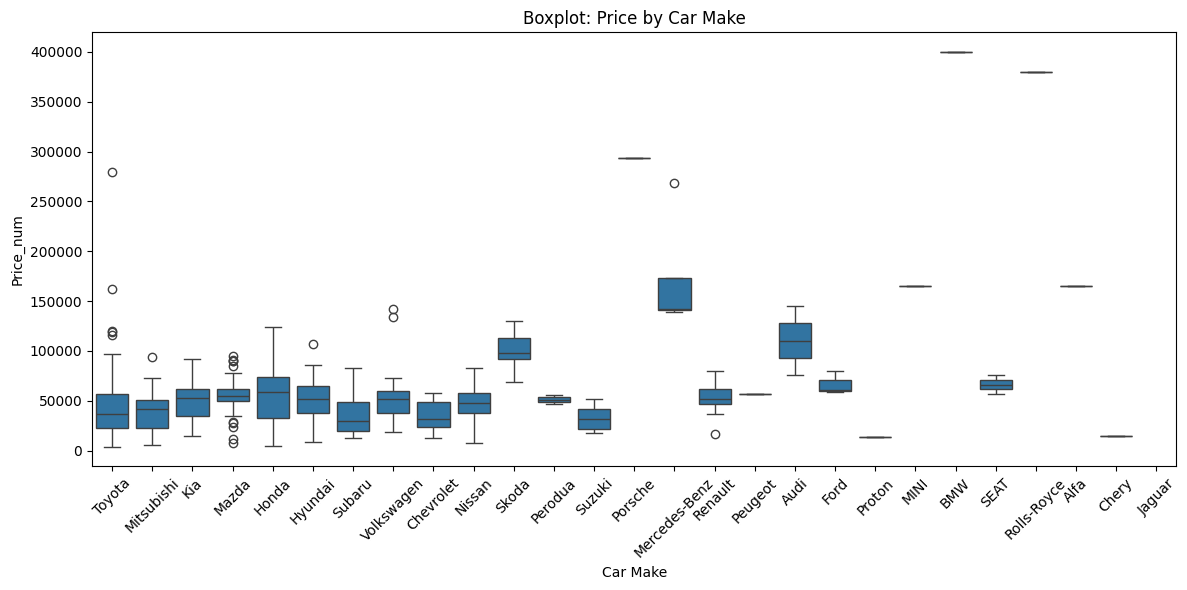

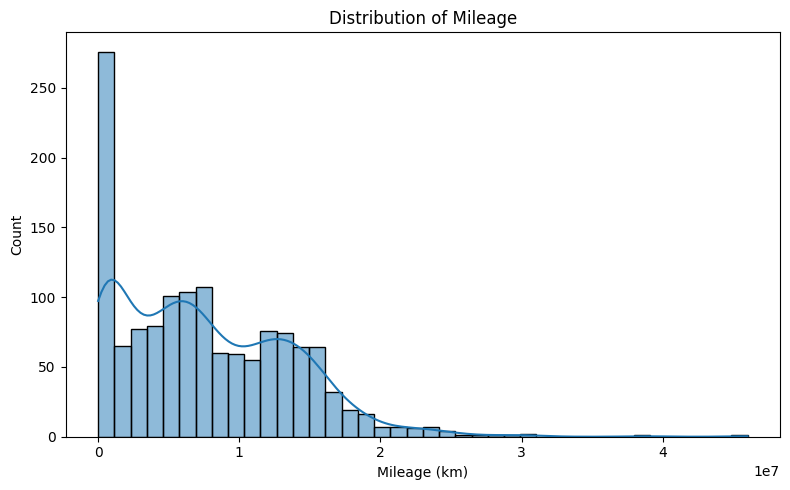

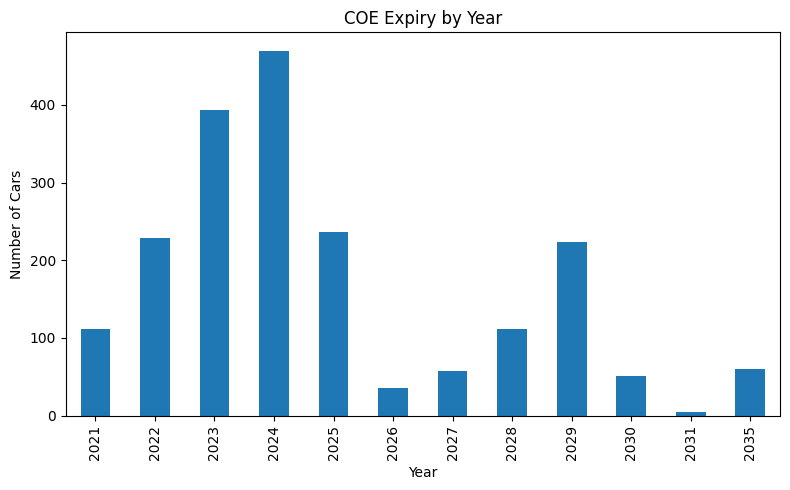

In [17]:
# --- Boxplot of Price by Car Make ---
if "Price_num" in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x="Car Make", y="Price_num")
    plt.title("Boxplot: Price by Car Make")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Histogram of Mileage ---
if "Mileage_num" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df["Mileage_num"], bins=40, kde=True)
    plt.title("Distribution of Mileage")
    plt.xlabel("Mileage (km)")
    plt.tight_layout()
    plt.show()

# --- COE Expiry Trend ---
coe_valid = df["COE End Date"].dropna()

if not coe_valid.empty:
    plt.figure(figsize=(8,5))
    coe_valid.dt.to_period("Y").value_counts().sort_index().plot(kind="bar")
    plt.title("COE Expiry by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Cars")
    plt.tight_layout()
    plt.show()

*KMeans clustering on Price & Mileage*

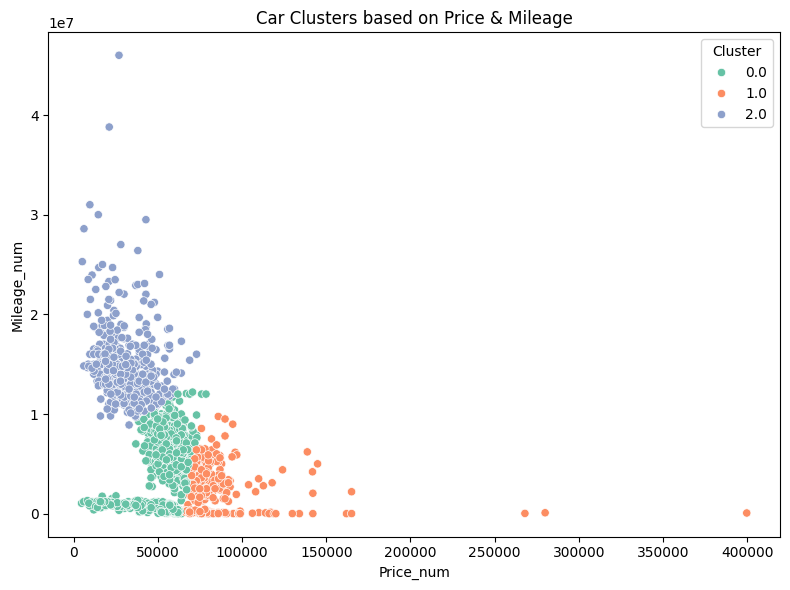

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = []
if "Price_num" in df.columns:
    features.append("Price_num")
if "Mileage_num" in df.columns:
    features.append("Mileage_num")

if len(features) >= 2:
    X = df[features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42)
    df.loc[X.index, "Cluster"] = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x="Price_num", y="Mileage_num", hue="Cluster", palette="Set2")
    plt.title("Car Clusters based on Price & Mileage")
    plt.tight_layout()
    plt.show()

In [22]:
df.to_csv("processed_masterdata.csv", index=False)
stats_df.to_csv("car_make_statistics.csv", index=False)

print("Saved: processed_masterdata.csv and car_make_statistics.csv")

Saved: processed_masterdata.csv and car_make_statistics.csv
